# Alzheimer Classifier

In this notebook, We will build a classifier to predict whether a patient has Alzheimer's disease or not. I will use a dataset that contains MRI images of the brain. The implementation is based on this [paper](https://www.researchgate.net/publication/349874169_A_CNN_based_framework_for_classification_of_Alzheimer's_disease).

# Introduction

Alzheimer's disease (AD) is a neurodegenerative disorder that causes memory loss and cognitive decline. It is the most common cause of dementia, accounting for 60-70% of cases. The exact cause of AD is unknown, but it is believed to be a combination of genetic, environmental, and lifestyle factors. There is currently no cure for AD, but early detection and treatment can help slow the progression of the disease. So the need for an accurate and reliable method for diagnosing AD is crucial.

In [266]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tqdm
import os
import sys
from PIL import Image
import cv2
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import data as tfdata
from tensorflow import image as tfimage
from tensorflow import io as tfio

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical, plot_model, img_to_array, normalize

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

## Dataset

The dataset used in this notebook is the [ADNI](https://www.kaggle.com/datasets/subhranilsarkar/alzheimer-s-disease-neuroimaging-adni-dataset) dataset from Kaggle. The dataset contains MRI images of the brain from patients with Alzheimer's disease and healthy controls. The dataset is divided into two classes: Mild Cognitive Impairment (MCI), and Alzheimer's disease (AD). The dataset contains a total of 1654 images, with 965 images from AD patients and 689 images from MCIs. For pre-processing, since most of the things are already done, we just need to resize the images to a fixed size.

In [267]:
AD_PATH = "../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD"
MCI_PATH = "../data/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI"

In [268]:
class ImageDataset:
    def __init__(self, AD_path: str, MCI_path: str, img_size: tuple[int, int] = (256, 256), batch_size: int = 32, **kwargs):
        self.AD_path = AD_path
        self.MCI_path = MCI_path
        self.img_size = img_size
        self.batch_size = batch_size
        self._load()
        
        
    def _load_image(self, path: str) -> tf.Tensor:
        img = tfio.read_file(path)
        img = tfio.decode_jpeg(img, channels=3)
        img = tfimage.resize(img, self.img_size)
        
        # img = tf.py_function(self._apply_dynamic_thresholding, [img], Tout=tf.uint8) 
        # uncomment the above line to apply dynamic thresholding
        
        img = tf.cast(img, tf.float32) / 255.0
        return img
    
    def _apply_dynamic_thresholding(self, img: tf.Tensor) -> tf.Tensor:
        img_np = img_to_array(img)
        img_np = (img_np * 255).astype(np.uint8)
        img_np = cv2.adaptiveThreshold(img_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        return tf.convert_to_tensor(img_np)
        
    def _load(self):
        MCI_files = tfio.gfile.glob(os.path.join(self.MCI_path, "*.jpg"))
        AD_files = tfio.gfile.glob(os.path.join(self.AD_path, "*.jpg"))
        
        MCI_data = tfdata.Dataset.from_tensor_slices(MCI_files)
        AD_data = tfdata.Dataset.from_tensor_slices(AD_files)
        
        MCI_data = MCI_data.map(self._load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        AD_data = AD_data.map(self._load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        MCI_label = tf.data.Dataset.from_tensor_slices([0] * len(MCI_files))
        AD_label = tf.data.Dataset.from_tensor_slices([1] * len(AD_files))
        
        MCI_data = tf.data.Dataset.zip((MCI_data, MCI_label))
        AD_data = tf.data.Dataset.zip((AD_data, AD_label))
        
        self.MCI_data = MCI_data
        self.AD_data = AD_data
        
        self.concat_data = tf.data.Dataset.concatenate(MCI_data, AD_data)
    
    
    
    def augment_image(self, img: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.1, 0.2)
        img = tf.image.random_hue(img, 0.1)
        img = tf.image.random_saturation(img, 0.1, 0.2)
        img = tf.image.random_crop(img, size=[*self.img_size, 1])
        return img, label
    
    def augment_dataset(self, num_samples: int = 4):
        MCI_data = self.MCI_data
        AD_data = self.AD_data
        
        for _ in range(num_samples):
            MCI_data = MCI_data.concatenate(self.MCI_data.map(self.augment_image))
            AD_data = AD_data.concatenate(self.AD_data.map(self.augment_image))
        
        self.MCI_data = MCI_data
        self.AD_data = AD_data
        
        self.concat_data = tf.data.Dataset.concatenate(MCI_data, AD_data)
            
            
                        
    def get_batch(self) -> tuple[tf.data.Dataset, tf.data.Dataset]:
        AD_data = self.AD_data.shuffle(1000).batch(self.batch_size)
        MCI_data = self.MCI_data.shuffle(1000).batch(self.batch_size)
        return AD_data, MCI_data
    
    def get_data(self) -> tuple[tf.data.Dataset, tf.data.Dataset]:
        return self.AD_data, self.MCI_data
    
    def get_sample_data(self, num_samples: int = 1) -> tuple[tf.Tensor, tf.Tensor]:
        AD_samples = [next(iter(self.AD_data.shuffle(buffer_size=100))) for _ in range(num_samples)]
        MCI_samples = [next(iter(self.MCI_data.shuffle(buffer_size=100))) for _ in range(num_samples)]
        return AD_samples, MCI_samples
    
    
    def split_train_test_validation(self, split_size: float = .05):
        dataset_size = len(self.concat_data)
        test_size = int(split_size * dataset_size)
        val_size = int(split_size * dataset_size * .1)
        train_size = dataset_size - test_size - val_size
        
        self.concat_data = self.concat_data.shuffle(dataset_size)
        
        self.test_data = self.concat_data.take(test_size)
        self.concat_data = self.concat_data.skip(test_size)
        
        self.validation_data = self.concat_data.take(val_size)
        self.concat_data = self.concat_data.skip(val_size)
        
        self.train_data = self.concat_data.take(train_size)
        self.concat_data = self.concat_data.skip(train_size)
        
    
    def show_sample(self, num_samples: int = 1):
        AD_samples, MCI_samples = self.get_sample_data(num_samples)
        
        figs, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples)) 
        if num_samples == 1:
            axes = axes[np.newaxis, :]
        for i in range(num_samples):
            axes[i, 0].imshow(AD_samples[i][0])
            axes[i, 0].set_title("AD")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(MCI_samples[i][0])
            axes[i, 1].set_title("MCI")
            axes[i, 1].axis("off")
        
        plt.show()
    
    def plot_distribution(self):
        plt.figure(figsize=(10, 5))
        
        sns.countplot(x="label", data=pd.DataFrame({"label": [0] * len(self.MCI_data) + [1] * len(self.AD_data)}))
        plt.xticks(ticks=[0, 1], labels=["MCI", "AD"])
        plt.show()

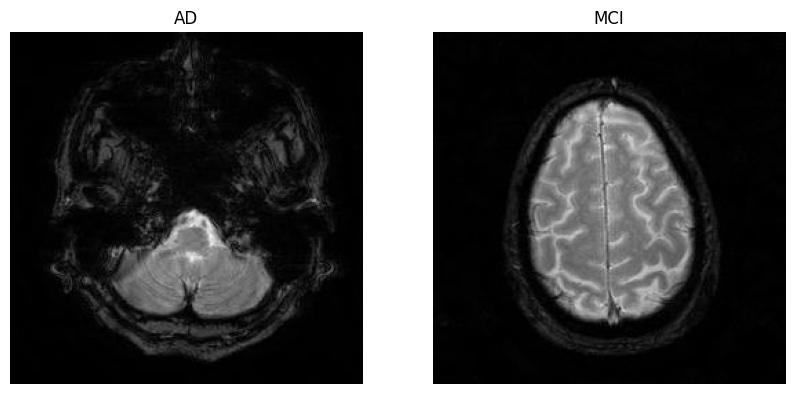

In [269]:
dataset = ImageDataset(AD_PATH, MCI_PATH)
dataset.show_sample()

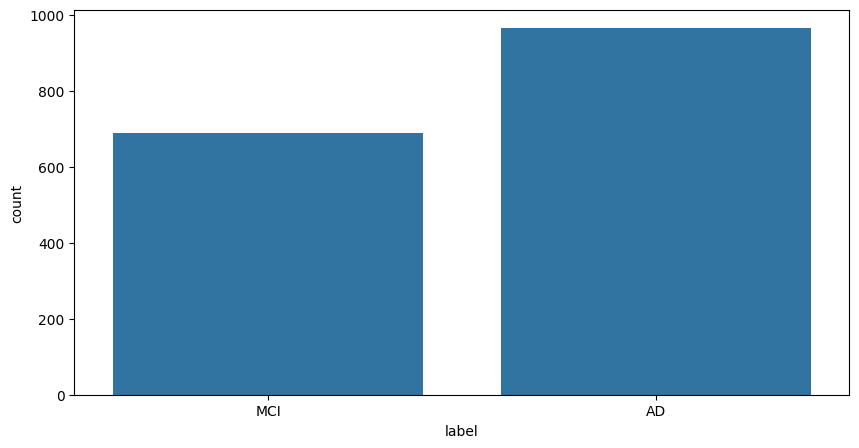

In [270]:
dataset.plot_distribution()

## Data Augmentation

Data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the images. This helps to improve the generalization of the model and reduce overfitting. In this notebook, we will use the `ImageDataGenerator` class from the `keras.preprocessing.image` module to perform data augmentation. We will apply random rotations, flips, shifts, and zooms to the images. 

In [271]:
dataset.augment_dataset()

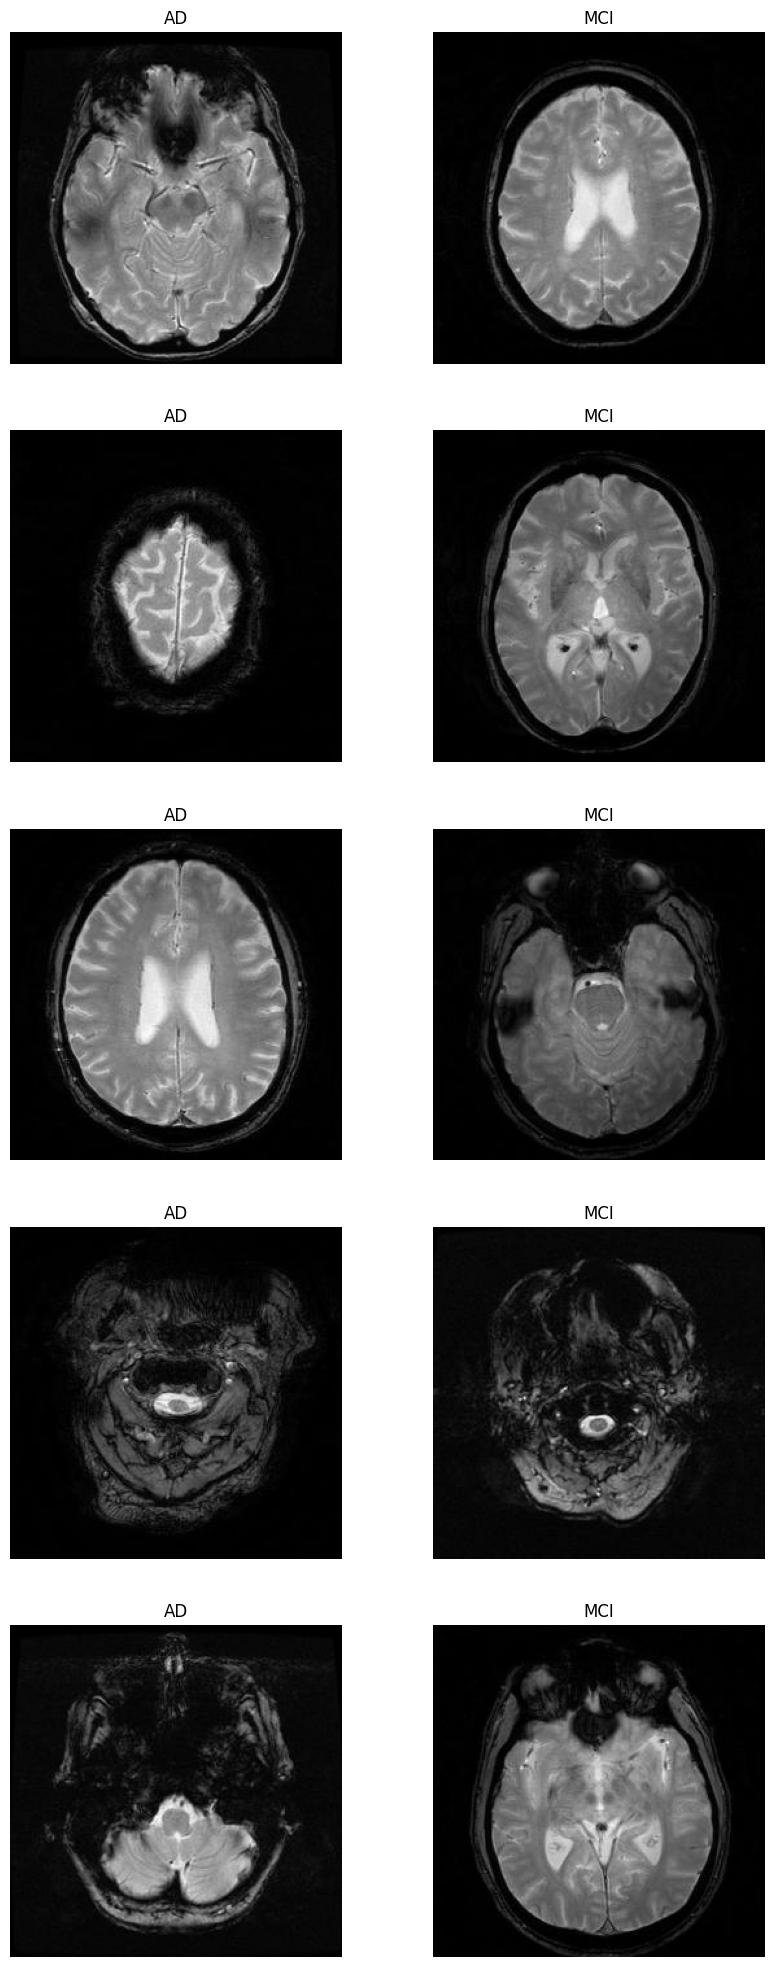

In [272]:
dataset.show_sample(5)

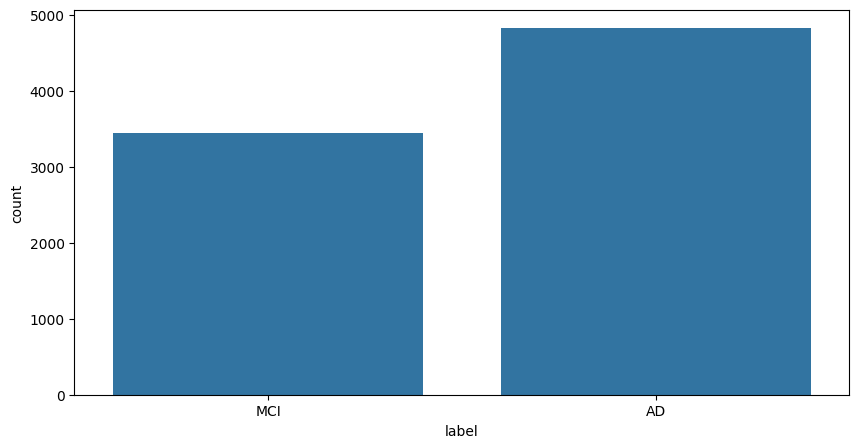

In [273]:
dataset.plot_distribution()

In [274]:
print(dataset.concat_data.element_spec)

(TensorSpec(shape=(256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [275]:
dataset.split_train_test_validation()
print(f"Train size     : {len(dataset.train_data)}")
print(f"Validation size: {len(dataset.validation_data)}")
print(f"Test size      : {len(dataset.test_data)}")

Train size     : 7816
Validation size: 41
Test size      : 413
